# Step 3 - Generate Sentence Vectors

This script is to generate sentence vectors using fasttext pretrained model and run a simple test.

Prerequisites:
    To run this script, a fasttext pretrained model is needed. 
    Download link: https://fasttext.cc/docs/en/english-vectors.html
Input: 
    1. database file
    2. answer file
Output:
    1. Sentence embedding files in .npy with the same name as database file
    2. A json file (same name as the database file but with additional text '_results' in it) including all search results

In [17]:
%pylab inline
import os
import json
from PIL import Image
import utilities as util
import vectors

Populating the interactive namespace from numpy and matplotlib


c:\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['title', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
"""
Make sure these variables are correctly set.
model: file path to pretrained model
database_file: file path to database file generated from previous steps
inquiry_file: a file with some example inquiries
moving_average_filter_enabled: whether or not to apply filter to sentence vectors. 
                               A separate numpy file will be generated with '_ma' in the file name
window_size: window size for the filter
"""

model = './visualization/backend/fasttext/wiki.en.bin' 
database_file = './visualization/backend/datasource/Life Is Strange 1/output/lifeisstrange_w_img_top3keywords.json'
inquiry_file = './visualization/backend/datasource/Life Is Strange 1/output/correct_answers.json'
enable_caption = True
enable_image_keyword = True
moving_average_filter_enabled = True
window_size = 5


In [19]:
%%time

word_embeddings = vectors.Vectors(model)
word_embeddings.load_word_vectors(mode='fasttext')
print(f'vector_size = {word_embeddings.vector_size}')

loading fasttext vectors
Wall time: 8min 22s


In [21]:
"""
get sentence vectors
"""
emb_foldername = "embeddings"
emb_foldername += "_img" if enable_image_keyword else ""
emb_foldername += "_cap" if enable_caption else ""

ind_dict = dict()
emb_dict_folder = os.path.dirname(database_file)
db_filename = os.path.splitext(os.path.basename(database_file))[0]
emb_dict_file = os.path.join(emb_dict_folder, db_filename + '_emb.json')
print(emb_dict_file)

sentence_vectors = np.empty((0, word_embeddings.vector_size))
sentence_vectors_filtered = np.empty((0, word_embeddings.vector_size))

with open(database_file, 'r') as input_file, \
    open(emb_dict_file, 'w') as output_file:
    json_str = input_file.read()
    database = json.loads(json_str)
    sentence_id = 0
    for file_idx, data in database.items():
        img_sessions = data['screenshots']['image_info']
        cap_sessions = data['captions']['captions']
        img_folder = data['screenshots']['image_folder']
        
        sentences = []
        for session_id, img_session in img_sessions.items():
            cap_text = cap_sessions[session_id]['text']
            for frame_id, frame_info in img_session['frames'].items():
                frame_keywords = ''
                if 'image_keywords' in frame_info.keys():
                    frame_keywords = frame_info['image_keywords']
                    frame_keywords = frame_keywords.replace('_', ' ')
                # print(f'{cap_text}, {frame_keywords}')    
                text_lst = []
                if enable_caption: text_lst.append(cap_text)
                if enable_image_keyword: text_lst.append(frame_keywords)
                    
                sentences.append(' '.join(text_lst))
                ind_dict[sentence_id] = (file_idx, session_id, frame_id)
                sentence_id += 1
        # print(f'sentences: {sentences}')            
        vectors = word_embeddings.generate_sentence_vectors(sentences) 
        sentence_vectors = np.concatenate((sentence_vectors, vectors))
        # print(sentence_vectors)
        # save vectors 
        img_folder = img_folder.replace('\\', '/') 
        emb_folder = os.path.join(os.path.dirname(img_folder), emb_foldername)
        print(f'img_folder: {img_folder}')
        if not os.path.exists(emb_folder):
            os.makedirs(emb_folder)
        embedding_file = os.path.join(emb_folder, 'embeddings')
        print(f'embedding shape: {vectors.shape}, embedding_file: {embedding_file}')
        np.save(embedding_file, vectors)
        
        # apply moving average filter
        if moving_average_filter_enabled:
            vector_filtered = util.moving_average(vectors, window_size)
            sentence_vectors_filtered = np.concatenate((sentence_vectors_filtered, vector_filtered))
            emb_folder = os.path.join(os.path.dirname(img_folder), emb_foldername + '_ma' + str(window_size))
            if not os.path.exists(emb_folder):
                os.makedirs(emb_folder)
            embedding_file = os.path.join(emb_folder, 'embeddings')
            np.save(embedding_file, vector_filtered)   
        
    if len(ind_dict.keys()) != vectors.shape[0]:
        print(f'number of sentences: {len(ind_dict.keys())}')

    json.dump(ind_dict, output_file, sort_keys=False, indent=4)


./visualization/backend/datasource/Life Is Strange 1/output\lifeisstrange_w_img_top3keywords_emb.json
23149
number of sentences: 23149


In [22]:
%%time
"""
Run test cases given a answer file including the following tests:

Testcase 1: Finding the most relevant sentences given a source sentence that appears in the real dialogues extracted. 
    This is to check whether the word embedding is correctly calculated. 
    
Testcase 2: Finding the most relevant sentences given a random combination of words. 
    This is to test whether the search can find semantically similar dialogues.
    
Testcase 3: Finding relevant images given some keywords. 
    This is to test whether the system can return useful results using the combination of sentence embeddings 
    and image keywords.

Results will be saved to a json file.
"""

if moving_average_filter_enabled:
    print(f'Moving average filter applied with window size {window_size}')
    result_file = os.path.join(emb_dict_folder, emb_foldername + '_ma' + str(window_size) + '_results.json')
    vec_pool = sentence_vectors_filtered
else:
    vec_pool = sentence_vectors
    result_file = os.path.join(emb_dict_folder, emb_foldername + '_results.json')

    
with open(result_file, 'w+') as rst_f, open(inquiry_file, 'r+') as inq_f:
    inquiry_database = json.loads(inq_f.read())
    result_str = rst_f.read()
    
    if len(result_str) > 0:
        result_data = json.loads(result_str)
    else:
        result_data = {}
    
    # sentence_dir = ['find the keys']
    sentence_dir = inquiry_database.keys()    
    
    for src_sentence_id, src_sentence in enumerate(sentence_dir):
        # get similar vectors, only used for bin
        print(f'User Inquiry: {src_sentence}')
        vec_sen = word_embeddings.get_sentence_vector(src_sentence, in_vocabulary = True) 
        if enable_caption or enable_image_keyword:
            neighbours = word_embeddings.find_nearest_neighbour(vec_sen, vec_pool)
        else:
            neighbours = util.random_neighbours(vec_sen, vec_pool)
        result_data[src_sentence] = []
        for top_n, (nb_id, distance) in enumerate(neighbours):
            file_id = ind_dict[nb_id][0]
            session_id = ind_dict[nb_id][1]
            key = ind_dict[nb_id][2]
            result_data[src_sentence].append({'file_id': file_id, 'session_id': session_id, 'frame_id': key, 'distance': distance})
    print(f'Results saved to {result_file}')
    json.dump(result_data, rst_f, indent=4)


Moving average filter applied with window size 5
User Inquiry: deduction scene
User Inquiry: rewind prompt
User Inquiry: Max fire alarm Chloe Rescue
User Inquiry: Butterfly Bucket
User Inquiry: Nathan Gun Chloe
User Inquiry: danger gun
User Inquiry: Time Freeze Kate Birds
User Inquiry: Kate Rooftop Max
User Inquiry: storm lightening
User Inquiry: storm cliff tornado
User Inquiry: toilet gun
User Inquiry: selfie classroom
User Inquiry: Max gallery
User Inquiry: Kate hospital
User Inquiry: Restaurant Jukebox
User Inquiry: swimming pool
User Inquiry: railway train stuck
User Inquiry: beacon
User Inquiry: sea sunset
User Inquiry: jukebox cafe
User Inquiry: jump okay okay I'm right here Kate
User Inquiry: Kate she did try to kill herself all
User Inquiry: Kate tried to kill herself
User Inquiry: Warren's new car
User Inquiry: Chloe Smoking
User Inquiry: Spirit Doe
User Inquiry: Jump
Results saved to ./visualization/backend/datasource/Life Is Strange 1/output\lifeisstrange_w_img_top3keywords

User Inquiry: deduction scene
top_n: 0, distance: 0.6094623561197539, file_id: 1, session_id: 290, frame_id: 75657, captions: being deductive as usual then what, Image keywords: wig seat_belt lab_coat
top_n: 1, distance: 0.5950776847501215, file_id: 1, session_id: 290, frame_id: 75538, captions: being deductive as usual then what, Image keywords: pajama wig gown
top_n: 2, distance: 0.5903084208867311, file_id: 1, session_id: 291, frame_id: 75688, captions: happened that's all I remember, Image keywords: wig brassiere Band_Aid
top_n: 3, distance: 0.5779848670903395, file_id: 1, session_id: 854, frame_id: 201441, captions: I'm going to predict four events that, Image keywords: wig Band_Aid brassiere
top_n: 4, distance: 0.5751769125039032, file_id: 1, session_id: 486, frame_id: 123258, captions: this job interview I can't believe I, Image keywords: turnstile sliding_door forklift
top_n: 5, distance: 0.5747852094463185, file_id: 2, session_id: 344, frame_id: 82030, captions: we're not kids

top_n: 6, distance: 0.7191545315334109, file_id: 3, session_id: 1084, frame_id: 245059, captions: well before Nathan comes back damn max, Image keywords: stole abaya gown
top_n: 7, distance: 0.7149617835704787, file_id: 4, session_id: 1041, frame_id: 279266, captions: I know neither were Chloe died new Chloe, Image keywords: stage suit abaya
top_n: 8, distance: 0.7148632992132411, file_id: 3, session_id: 1083, frame_id: 244792, captions: Nathan's phone so I can show it to Chloe, Image keywords: abaya brassiere jean
top_n: 9, distance: 0.7090303810116282, file_id: 2, session_id: 526, frame_id: 125556, captions: here I should go join Chloe now max you, Image keywords: desktop_computer desk screen
User Inquiry: danger gun
top_n: 0, distance: 0.6938939895412095, file_id: 0, session_id: 1305, frame_id: 285960, captions: thought you believed in gun control yes, Image keywords: stethoscope window_shade maillot
top_n: 1, distance: 0.6935972028732124, file_id: 0, session_id: 1306, frame_id: 285

top_n: 2, distance: 0.6649804264479654, file_id: 4, session_id: 1705, frame_id: 430010, captions: this is my storm I caused it icons of, Image keywords: cliff valley alp
top_n: 3, distance: 0.6577227097119971, file_id: 4, session_id: 1705, frame_id: 430129, captions: this is my storm I caused it icons of, Image keywords: feather_boa goldfish macaw
top_n: 4, distance: 0.6486135473262453, file_id: 1, session_id: 24, frame_id: 4673, captions: tornado max tell me everything, Image keywords: grey_whale great_white_shark wreck
top_n: 5, distance: 0.6408876669651834, file_id: 0, session_id: 1457, frame_id: 318846, captions: oh my lord the tornado is back, Image keywords: missile projectile space_shuttle
top_n: 6, distance: 0.6404605073405913, file_id: 4, session_id: 1704, frame_id: 429792, captions: , Image keywords: alp volcano great_white_shark
top_n: 7, distance: 0.6382442523361683, file_id: 1, session_id: 24, frame_id: 4917, captions: tornado max tell me everything, Image keywords: lakesi

User Inquiry: Restaurant Jukebox
top_n: 0, distance: 0.7755225944529365, file_id: 0, session_id: 241, frame_id: 49996, captions: answer, Image keywords: restaurant china_cabinet bakery
top_n: 1, distance: 0.7701572276869492, file_id: 2, session_id: 1258, frame_id: 289294, captions: nevermind me officer I'm just here to, Image keywords: television slot home_theater
top_n: 2, distance: 0.7683576330281574, file_id: 0, session_id: 242, frame_id: 50020, captions: , Image keywords: restaurant china_cabinet barbershop
top_n: 3, distance: 0.7666297967876953, file_id: 2, session_id: 1402, frame_id: 315826, captions: , Image keywords: stole pool_table barbershop
top_n: 4, distance: 0.7623221304969121, file_id: 2, session_id: 1402, frame_id: 315945, captions: , Image keywords: restaurant barbershop pool_table
top_n: 5, distance: 0.759872168396213, file_id: 3, session_id: 1638, frame_id: 387176, captions: , Image keywords: candle restaurant wok
top_n: 6, distance: 0.7585664961920987, file_id: 0, s

top_n: 2, distance: 0.6770971477174997, file_id: 3, session_id: 592, frame_id: 139978, captions: rewind fine whatevs, Image keywords: bookshop bakery restaurant
top_n: 3, distance: 0.6735064913846788, file_id: 0, session_id: 241, frame_id: 49996, captions: answer, Image keywords: restaurant china_cabinet bakery
top_n: 4, distance: 0.6724777161810555, file_id: 1, session_id: 1395, frame_id: 324707, captions: max we'll talk again real soon, Image keywords: restaurant barbershop library
top_n: 5, distance: 0.6715310929499836, file_id: 2, session_id: 1257, frame_id: 289284, captions: , Image keywords: bubble restaurant slot
top_n: 6, distance: 0.6680638217329204, file_id: 0, session_id: 242, frame_id: 50139, captions: , Image keywords: restaurant projector laptop
top_n: 7, distance: 0.6676031261718298, file_id: 3, session_id: 592, frame_id: 140091, captions: rewind fine whatevs, Image keywords: shoe_shop toyshop restaurant
top_n: 8, distance: 0.6674987654173503, file_id: 1, session_id: 148

User Inquiry: Chloe Smoking
top_n: 0, distance: 0.7101129529029483, file_id: 1, session_id: 1141, frame_id: 272286, captions: are you okay max seriously Chloe this is, Image keywords: bathing_cap ski_mask ballplayer
top_n: 1, distance: 0.6994097893274688, file_id: 3, session_id: 383, frame_id: 86003, captions: this Chloe and I lucky to have him Chloe, Image keywords: wig crossword_puzzle jean
top_n: 2, distance: 0.6970813898388735, file_id: 1, session_id: 1141, frame_id: 272167, captions: are you okay max seriously Chloe this is, Image keywords: sleeping_bag swing mountain_tent
top_n: 3, distance: 0.6958187537822224, file_id: 0, session_id: 1001, frame_id: 214038, captions: bathroom max Chloe no way you again get, Image keywords: bannister window_shade shoe_shop
top_n: 4, distance: 0.693282279840019, file_id: 1, session_id: 631, frame_id: 155781, captions: know Chloe down at the station, Image keywords: prison perfume cellular_telephone
top_n: 5, distance: 0.6915341140593, file_id: 1, 

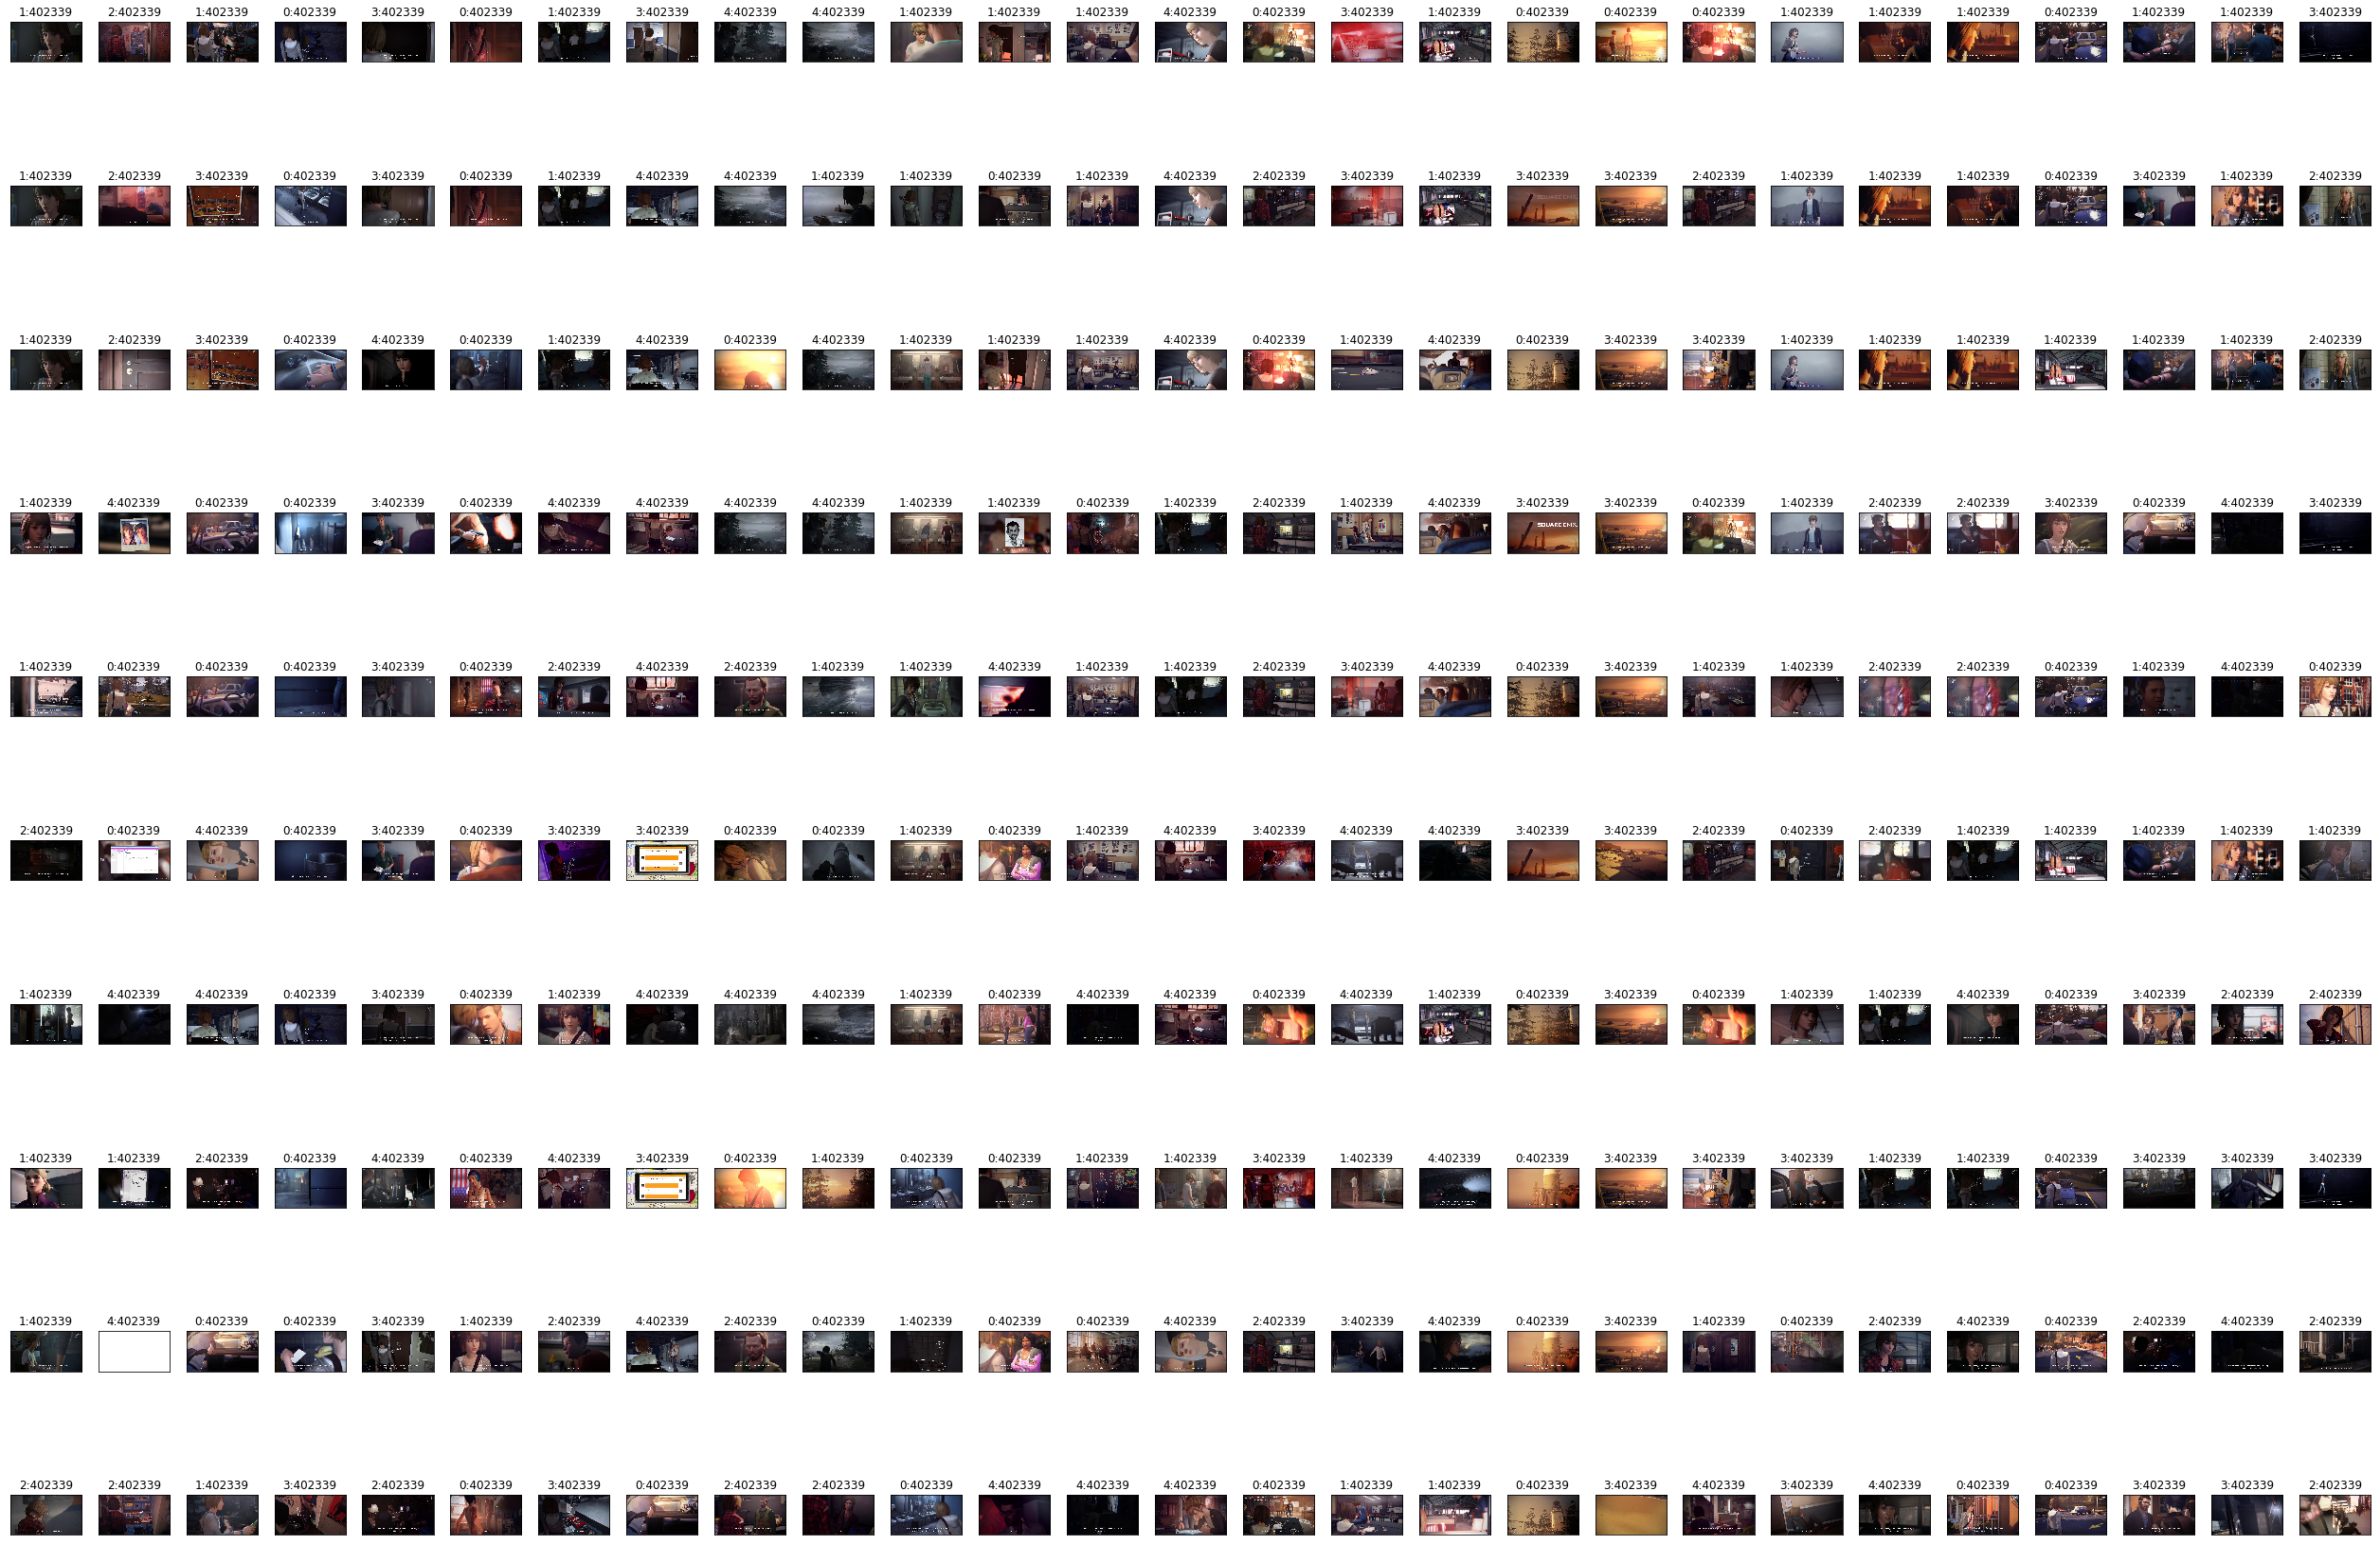

In [23]:
"""
Print out search results. 
To display only one result, just comment out line 7 and use line 6 instead, and 
replace that string with another inquiry listed in the answer file.
"""
# sentence_dir = ["party"]
sentence_dir = inquiry_database.keys()
top_n_neighbours = 10
if len(sentence_dir) > 1:
    fig, axes = plt.subplots(top_n_neighbours, len(sentence_dir), figsize=(35, 25), subplot_kw={'xticks': [], 'yticks': []})

for src_sentence_id, src_sentence in enumerate(sentence_dir):
    print(f'User Inquiry: {src_sentence}')
    for top_n, rst in enumerate(result_data[src_sentence][:top_n_neighbours]):
        distance = rst['distance']
        file_id = rst['file_id']
        session_id = rst['session_id']
        img_folder = database[file_id]['screenshots']['image_folder']
        img_sessions = database[file_id]['screenshots']['image_info']
        frame_id = rst['frame_id']
        img_file = img_sessions[session_id]['frames'][frame_id]['image_file']
        img_file = os.path.join(img_folder, img_file)
        image = Image.open(img_file) 
        cap_text = database[file_id]['captions']['captions'][session_id]['text']
        img_keywords = ''
        if 'image_keywords' in img_sessions[session_id]['frames'][frame_id].keys():
            img_keywords = img_sessions[session_id]['frames'][frame_id]['image_keywords']
        print(f'top_n: {top_n}, distance: {distance}, file_id: {file_id}, session_id: {session_id}, frame_id: {frame_id}, captions: {cap_text}, Image keywords: {img_keywords}')
        
        title = f'{file_id}:{key}'
        if len(sentence_dir) > 1:
            axes[top_n][src_sentence_id].imshow(np.asarray(image))
            axes[top_n][src_sentence_id].set_title(title)
        else:
            plt.figure()
            plt.imshow(image)
    
if len(sentence_dir) > 1:
    fig.tight_layout()       
    plt.show()